In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

<IPython.core.display.Javascript object>

In [3]:
def print_vif(x, get_vifs=False):
    import warnings
    import statsmodels.api as sm
    from statsmodels.stats.outliers_influence import variance_inflation_factor

    """Utility for checking multicollinearity assumption
    
    :param x: input features to check using VIF. This is assumed to be a pandas.DataFrame
    :return: nothing is returned the VIFs are printed as a pandas series
    """
    # Silence numpy FutureWarning about .ptp
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        x = sm.add_constant(x)

    vifs = []
    for i in range(x.shape[1]):
        vif = variance_inflation_factor(x.values, i)
        vifs.append(vif)

    print("VIF results\n-------------------------------")
    print(pd.Series(vifs, index=x.columns))
    print("-------------------------------\n")

    if get_vifs == True:
        return vifs

<IPython.core.display.Javascript object>

In [4]:
def eval_preds(y_true, y_pred):
    error = y_true - y_pred

    rmse = np.sqrt((error ** 2).mean())
    mae = error.abs().mean()
    mape = (error / y_true).abs().mean()

    print(f"rmse {rmse:.2f}")
    print(f"mae {mae:.2f}")
    print(f"mape {mape:.2f}")

    line_pts = [y_true.min(), y_true.max()]
    plt.scatter(y_true, y_pred)
    plt.plot(line_pts, line_pts, c="red", ls="--", alpha=0.5)
    plt.xlabel("Actual")
    plt.ylabel("Fit")
    plt.show()

<IPython.core.display.Javascript object>

# Data and Goal
The data is taken from [this Kaggle Source](https://www.kaggle.com/loveall/appliances-energy-prediction?select=KAG_energydata_complete.csv). The goal will be to predict the energy usage for the house based on the features available. Linear Regression and KNN Regression will be considered to optimize performance.

### Data Cleaning

In [5]:
energy = pd.read_csv("data/KAG_energydata_complete.csv")

<IPython.core.display.Javascript object>

In [6]:
energy.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


<IPython.core.display.Javascript object>

In [7]:
energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         19735 non-null  object 
 1   Appliances   19735 non-null  int64  
 2   lights       19735 non-null  int64  
 3   T1           19735 non-null  float64
 4   RH_1         19735 non-null  float64
 5   T2           19735 non-null  float64
 6   RH_2         19735 non-null  float64
 7   T3           19735 non-null  float64
 8   RH_3         19735 non-null  float64
 9   T4           19735 non-null  float64
 10  RH_4         19735 non-null  float64
 11  T5           19735 non-null  float64
 12  RH_5         19735 non-null  float64
 13  T6           19735 non-null  float64
 14  RH_6         19735 non-null  float64
 15  T7           19735 non-null  float64
 16  RH_7         19735 non-null  float64
 17  T8           19735 non-null  float64
 18  RH_8         19735 non-null  float64
 19  T9  

<IPython.core.display.Javascript object>

In [8]:
energy.isna().sum()

date           0
Appliances     0
lights         0
T1             0
RH_1           0
T2             0
RH_2           0
T3             0
RH_3           0
T4             0
RH_4           0
T5             0
RH_5           0
T6             0
RH_6           0
T7             0
RH_7           0
T8             0
RH_8           0
T9             0
RH_9           0
T_out          0
Press_mm_hg    0
RH_out         0
Windspeed      0
Visibility     0
Tdewpoint      0
rv1            0
rv2            0
dtype: int64

<IPython.core.display.Javascript object>

In [9]:
# extract datetime down to the hour
energy["date"] = pd.to_datetime(energy["date"])

<IPython.core.display.Javascript object>

In [10]:
energy["hour"] = energy["date"].dt.hour
energy["month"] = energy["date"].dt.month_name()
energy["dayofweek"] = energy["date"].dt.day_name()

<IPython.core.display.Javascript object>

In [11]:
energy["month"]

0        January
1        January
2        January
3        January
4        January
          ...   
19730        May
19731        May
19732        May
19733        May
19734        May
Name: month, Length: 19735, dtype: object

<IPython.core.display.Javascript object>

In [12]:
energy.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,hour,month,dayofweek
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433,17,January,Monday
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195,17,January,Monday
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668,17,January,Monday
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389,17,January,Monday
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097,17,January,Monday


<IPython.core.display.Javascript object>

In [13]:
energy.describe()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,hour
count,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,...,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
mean,97.694958,3.801875,21.686571,40.259739,20.341219,40.420420,22.267611,39.242500,20.855335,39.026904,...,41.552401,7.411665,755.522602,79.750418,4.039752,38.330834,3.760707,24.988033,24.988033,11.502002
std,102.524891,7.935988,1.606066,3.979299,2.192974,4.069813,2.006111,3.254576,2.042884,4.341321,...,4.151497,5.317409,7.399441,14.901088,2.451221,11.794719,4.194648,14.496634,14.496634,6.921953
min,10.000000,0.000000,16.790000,27.023333,16.100000,20.463333,17.200000,28.766667,15.100000,27.660000,...,29.166667,-5.000000,729.300000,24.000000,0.000000,1.000000,-6.600000,0.005322,0.005322,0.000000
25%,50.000000,0.000000,20.760000,37.333333,18.790000,37.900000,20.790000,36.900000,19.530000,35.530000,...,38.500000,3.666667,750.933333,70.333333,2.000000,29.000000,0.900000,12.497889,12.497889,6.000000
50%,60.000000,0.000000,21.600000,39.656667,20.000000,40.500000,22.100000,38.530000,20.666667,38.400000,...,40.900000,6.916667,756.100000,83.666667,3.666667,40.000000,3.433333,24.897653,24.897653,12.000000
75%,100.000000,0.000000,22.600000,43.066667,21.500000,43.260000,23.290000,41.760000,22.100000,42.156667,...,44.338095,10.408333,760.933333,91.666667,5.500000,40.000000,6.566667,37.583769,37.583769,17.000000
max,1080.000000,70.000000,26.260000,63.360000,29.856667,56.026667,29.236000,50.163333,26.200000,51.090000,...,53.326667,26.100000,772.300000,100.000000,14.000000,66.000000,15.500000,49.996530,49.996530,23.000000


<IPython.core.display.Javascript object>

In [14]:
energy["Appliances"].sort_values(ascending=False).head(50)

731      1080
1451     1070
432       910
12088     900
1452      890
10668     880
14693     870
9031      860
1821      850
19582     850
15798     840
1307      830
19541     820
13821     820
13786     800
867       800
1823      800
443       790
868       790
18820     790
12068     790
15664     780
2749      780
9313      780
10621     780
13252     770
6444      770
9369      760
8218      760
12676     760
12089     760
12049     750
12216     750
732       750
14662     750
4011      750
13256     750
4475      750
1031      740
5000      740
9030      740
431       740
9366      740
12243     730
13820     730
12069     730
18830     720
12087     720
14640     720
14663     720
Name: Appliances, dtype: int64

<IPython.core.display.Javascript object>

### Model Preparation

In [15]:
X = energy.drop(columns=["date", "Appliances"])
y = energy["Appliances"]

<IPython.core.display.Javascript object>

In [16]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

<IPython.core.display.Javascript object>

In [20]:
vifs = print_vif(X.select_dtypes(exclude='object'), get_vifs=True)


VIF results
-------------------------------
const          2.021849e+04
lights         1.300539e+00
T1             1.999564e+01
RH_1           1.622931e+01
T2             2.882409e+01
RH_2           2.190367e+01
T3             1.005874e+01
RH_3           1.082785e+01
T4             9.852063e+00
RH_4           1.739351e+01
T5             1.053141e+01
RH_5           1.398892e+00
T6             3.374728e+01
RH_6           9.997883e+00
T7             1.750271e+01
RH_7           1.083110e+01
T8             8.133927e+00
RH_8           9.329784e+00
T9             2.934493e+01
RH_9           6.874161e+00
T_out          1.468628e+02
Press_mm_hg    1.406927e+00
RH_out         4.963714e+01
Windspeed      1.609972e+00
Visibility     1.041370e+00
Tdewpoint      8.714399e+01
rv1                     inf
rv2                     inf
hour           2.105932e+00
dtype: float64
-------------------------------



C:\Users\dgump\miniconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


<IPython.core.display.Javascript object>

In [26]:
energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 32 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         19735 non-null  datetime64[ns]
 1   Appliances   19735 non-null  int64         
 2   lights       19735 non-null  int64         
 3   T1           19735 non-null  float64       
 4   RH_1         19735 non-null  float64       
 5   T2           19735 non-null  float64       
 6   RH_2         19735 non-null  float64       
 7   T3           19735 non-null  float64       
 8   RH_3         19735 non-null  float64       
 9   T4           19735 non-null  float64       
 10  RH_4         19735 non-null  float64       
 11  T5           19735 non-null  float64       
 12  RH_5         19735 non-null  float64       
 13  T6           19735 non-null  float64       
 14  RH_6         19735 non-null  float64       
 15  T7           19735 non-null  float64       
 16  RH_7

<IPython.core.display.Javascript object>

In [30]:
num_cols = [
    "lights",
    "T4",
    "RH_5",
    "T8",
    "RH_8",
    "RH_9",
    "Press_mm_hg",
    "Windspeed",
    "Visibility",
    "hour",
    # "day", # possibly try day of month
]

cat_cols = [
    "dayofweek",
    "month",
]


<IPython.core.display.Javascript object>

In [32]:
X = energy[num_cols + cat_cols]
print_vif(X[num_cols])

VIF results
-------------------------------
const          14147.962360
lights             1.105807
T4                 2.933076
RH_5               1.236383
T8                 3.164361
RH_8               4.345430
RH_9               3.937652
Press_mm_hg        1.207570
Windspeed          1.219438
Visibility         1.022956
hour               1.278802
dtype: float64
-------------------------------



<IPython.core.display.Javascript object>

In [53]:
all_cols = X.columns.to_list()
all_cols

['lights',
 'T4',
 'RH_5',
 'T8',
 'RH_8',
 'RH_9',
 'Press_mm_hg',
 'Windspeed',
 'Visibility',
 'hour',
 'dayofweek',
 'month']

<IPython.core.display.Javascript object>

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

<IPython.core.display.Javascript object>

#### Linear Regression

In [55]:
lr_preprocessing = ColumnTransformer(
    [("onehot", OneHotEncoder(drop="first"), cat_cols)], remainder="passthrough"
)  # none yet

<IPython.core.display.Javascript object>

In [56]:
lr_pipeline = Pipeline(
    [("lr_preprocessing", lr_preprocessing), ("lr_reg", LinearRegression())]
)

<IPython.core.display.Javascript object>

In [57]:
lr_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('lr_preprocessing',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('onehot',
                                                  OneHotEncoder(categories='auto',
                                                                drop='first',
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='error',
                                                                sparse=True),
                                                  ['dayofweek', 'month'])],
                                   verbose=False)),
                ('lr_reg',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                 

<IPython.core.display.Javascript object>

In [58]:
lr_pipeline.score(X_train, y_train)

0.09047571751508443

<IPython.core.display.Javascript object>

In [59]:
lr_pipeline.score(X_test, y_test)

0.0951521181663979

<IPython.core.display.Javascript object>

rmse 96.98
mae 55.36
mape 0.63


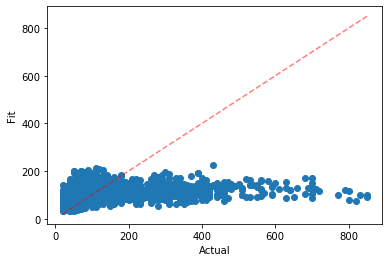

<IPython.core.display.Javascript object>

In [60]:
y_pred = lr_pipeline.predict(X_test)
eval_preds(y_test, y_pred)

In [61]:
lr_pipeline = Pipeline(
    [("lr_preprocessing", lr_preprocessing), ("lr_reg", LinearRegression())]
)
y_train_logged = np.log(y_train)
y_test_logged = np.log(y_test)

lr_pipeline.fit(X_train, y_train_logged)
print("Trian score: {}".format(lr_pipeline.score(X_train, y_train_logged)))

Trian score: 0.19017279099452009


<IPython.core.display.Javascript object>

rmse 0.59
mae 0.41
mape 0.09


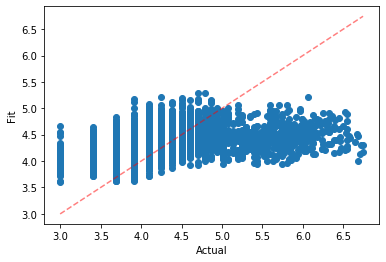

<IPython.core.display.Javascript object>

In [62]:
y_pred = lr_pipeline.predict(X_test)
eval_preds(y_test_logged, y_pred)

#### KNN Regression

In [67]:
# want to onehot encode, then scale so all columns including new onehot categories are suitable
# for knn regression

knn_onehot = ColumnTransformer(
    [
        ("onehot", OneHotEncoder(drop="first"), cat_cols),
    ],
)

knn_scaler = ColumnTransformer()
("scaler", StandardScaler(), )

<IPython.core.display.Javascript object>

In [ ]:
knn_pipeline = Pipeline(
    [("preprocessing", knn_preprocessing), ("knn", KNeighborsRegressor()),]
)

In [65]:
knn_pipeline.fit(X_train, y_train)

ValueError: could not convert string to float: 'Wednesday'

<IPython.core.display.Javascript object>

In [ ]:
knn_pipeline.score(X_train, y_train)

In [ ]:
knn_pipeline.score(X_test, y_test)

Looks to be over fit, but markedly better than the OLS regression. Further tuning will be needed for both

In [ ]:
y_pred = knn_pipeline.predict(X_test)

eval_preds(y_test, y_pred)
# looks like we are over predicitng large values

In [ ]:
grid = {
    "knn__n_neighbors": np.arange(1, 30, 3),
    "knn__weights": ["uniform", "distance"],
}

In [ ]:
knn_pipeline_cv = GridSearchCV(knn_pipeline, grid, verbose=1)

In [ ]:
knn_pipeline_cv = knn_pipeline_cv.fit(X_train, y_train)

In [ ]:
knn_pipeline_cv.best_params_
# chose n = 7, weights = 'distance'

In [ ]:
knn_pipeline_cv.score(X_test, y_test)

In [ ]:
knn_pipeline_cv.score(X_train, y_train)

In [ ]:
y_pred = knn_pipeline_cv.predict(X_test)
eval_preds(y_test, y_pred)

In [ ]:
y_train_logged = np.log(y_train)
y_test_logged = np.log(y_test)

knn_pipeline_cv = GridSearchCV(knn_pipeline, grid, verbose=1)
knn_pipeline_cv = knn_pipeline_cv.fit(X_train, y_train_logged)

In [ ]:
knn_pipeline_cv.best_params_


In [ ]:
knn_pipeline_cv.score(X_test, y_test_logged)

In [ ]:
knn_pipeline_cv.score(X_train, y_train_logged)

In [ ]:
y_pred = knn_pipeline_cv.predict(X_test)
eval_preds(y_test_logged, y_pred)

In [ ]:
X_train

### Results and Discussion

With an OLS linear regression model, $r^2$ values of 0.8 and 0.7 were found for the training and test data respectively. Given the heavy heteroscedasticity in the errors, and an MAPE of 61%, this model performed very poorly. So poorly, I am skeptical the data is suited to this model. This will be evaluated. 

For the KNN regression, the data was scaled using a standard scaler and grid search was done to tune the model. The best parameters were found to be k = 4 with weighting by distance. $r^2$ for this model's train and test sets were 1.0 and 0.46. With a 'perfect' training score, this model is overfit and may not generalize well. The MAPE was 35%, along with very heteroscedastic errors. 

Although the test data isn't strongly shape, the target variable is evenly distributed from 10 into the thousands. with this kind of spread, a log transform might allow for better analysis of variance in the target variable. Transforming y with the OLS model resulted in marginal improvement, and the distribution of errors is undesirable.

Running KNN regression with the logged target resulted in much better performance. The model was still overfit with scores of 1.0 a,d 0.64, but the error distribution is much more desirable. High and low values are under and over predicted respectively. The MAPE was only 6%. This is modest, but good given the shape of the errors. 

With some data engineering, the OLS model might perform better, but from these findings, the KNN regressor was a much better predictor. Since the data was tidy, the KNN model's agnostic nature paid off for work versus reward. However, the linear regressor would offer more interpretability. 